# Db2 Row and Column Access Control (RCAC)

Row permissions and column masks are two database concepts in Db2 that address the shortcomings of traditional security methods. These features act as a second layer of security that complements the table privileges security model available in prior releases of Db2.

One advantage of row permissions and column masks is that no database user is automatically exempted from them — not even users with the DATAACCESS authority. The ability to manage row permissions and column masks within a database is vested solely in a user with SECADM, thereby ensuring that users with DATAACCESS authority can no longer freely access all data in the database.
   
Another key advantage is that row permissions and column masks ensure that table data is protected regardless of how the SQL accesses the table, be it through an application, through ad hoc query tools, or through report generation tools.
   
Finally, and perhaps most significantly, row permissions and column masks require no application changes; RCAC is transparent to existing applications.

In this lab we are using HMO (Health Maintenance Organization) data to demonstrate RCAC. 

This scenario presents the fictitious organization called ExampleHMO, a national organization with a large and active list of patients, as a user of row and column access control. ExampleHMO uses row and column access control to ensure that their database policies reflect government regulatory requirements for privacy and security, as well as management business objectives.

Organizations that handle patient health information and their personal information, like ExampleHMO, must comply with government privacy and data protection regulations, for example the Health Insurance Portability and Accountability Act (HIPAA). These privacy and data protection regulations ensure that any sensitive patient medical or personal information is shared, viewed, and modified only by authorities who are privileged to do so. Any violation of the act results in huge penalties including civil and criminal suits.

ExampleHMO must ensure that the data stored in their database systems is secure and only privileged users have access to the data. According to typical privacy regulations, certain patient information can be accessed and modified by only privileged users.

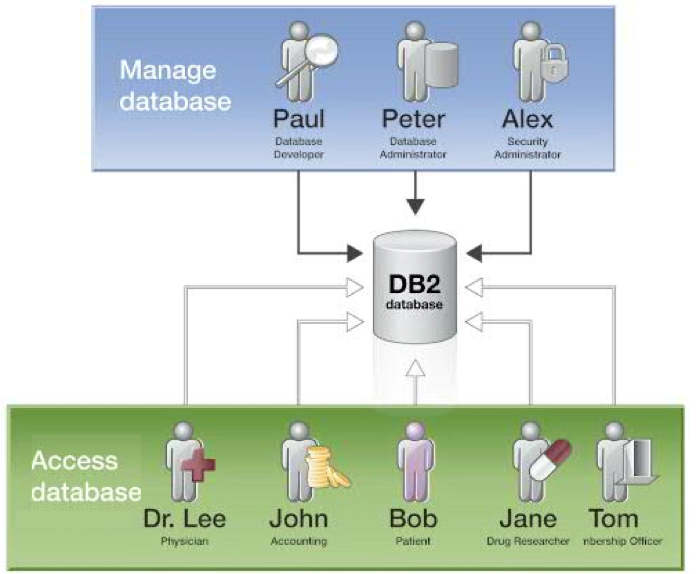

In [1]:
%run ../db2.ipynb

DB2 Extensions Loaded.


In [ ]:
!easy_install ibm_db

<a id='top'></a>
## Table of Contents

* [Security policies](#policies)
* [Database users and roles](#users)
* [Database tables](#tables)
* [Security administration](#secadm)
* [Row permissions](#rowperm)
* [Column masks](#colmask)
* [Data manipulation](#users)
  * [Data insertion](#insert)
  * [Data updates](#update)
* [Data queries](#query)
* [View creation](#view)
* [Secure functions](#secfct)
* [Secure triggers](#trigger)
* [Revoke authority](#revoke)
<p>
* [Answers](#answers)
* [Clean all](#clean)
    

[Back to Top](#top)

## Security policies <a id='policies'></a>

ExampleHMO implements a security strategy where data access to databases are made available according to certain security policies.

The security policies conform to government privacy and data protection regulations. The first column outlines the policies and the challenges faced by the organization, the second column outlines the row and column access control feature which addresses the challenge.

<table> 
    <thead> <tr> 
        <th style="text-align:left;" width=300px>Security challenge </th> 
        <th>Row and column access control feature which addresses the security challenge</th>  
    </tr> </thead> 
    <tbody> 
        <tr> 
            <td style="text-align:left;">Limiting column access to only privileged users. For example, Jane, who is a drug researcher at a partner company, is not permitted to view sensitive patient medical information or personal data like their insurance number.</td> 
            <td style="text-align:left;">Column masks can be used to filter or hide sensitive data from Jane.</td> 
        </tr> 
        <tr> 
            <td style="text-align:left;">Limiting row access to only privileged users. Dr. Lee is only permitted to view patient information for his own patients, not all patients in the ExampleHMO system.</td> 
            <td style="text-align:left;">Row permissions can be implemented to control which user can view any particular row.</td>
        </tr> 
        <tr> 
            <td style="text-align:left;">Restricting data on a need-to-know basis.</td> 
            <td style="text-align:left;">Row permissions can help with this challenge as well by restricting table level data at the user level.</td>
        </tr> 
        <tr> 
            <td style="text-align:left;">Restricting other database objects like UDFs, triggers, views on RCAC secured data.</td> 
            <td style="text-align:left;">Row and column access control protects data at the data level. It is this data-centric nature of the row and column access control solution that enforces security policies on even database objects like UDFs, triggers, and views.</td>
        </tr> 
    </tbody> 
</table>

[Back to Top](#top)

## Database users and roles <a id='users'></a>

In this scenario, a number of different people create, secure, and use ExampleHMO data. These people have different user rights and database authorities.

ExampleHMO implemented their security strategy to classify the way data is accessed from the database. Internal and external access to data is based on the separation of duties to users who access the data and their data access privileges. ExampleHMO created the following database roles to separate these duties:

--> tabelle mit IDs und Rollen
    
| Role          | Duty                         |
|:--------------|:-----------------------------|
| PCP           | For primary care physicians. |
| DRUG_RESEARCH | For researchers.             |
| ACCOUNTING    | For accountants.             |
| MEMBERSHIP    | For members who add patients for opt-in and opt-out.  |
| PATIENT       | For patients.                |
|               |                              |

The following people create, secure, and use ExampleHMO data:
    
* **`Alex`**     Chief Security Administrator. He holds the SECADM authority.
* **`Peter`**    Database Administrator. He holds the DBADM authority.
* **`Paul`**     Database Developer. He has the privileges to create triggers and user-defined functions.
* **`Dr. Lee`**     Physician. He belongs to the PCP role.
* **`Jane`**     Drug researcher at Innovative Pharmaceutical Company, a ExampleHMO partner. She belongs to the DRUG_RESEARCH role.
* **`John`**     Accounting Department. He belongs to the ACCOUNTING role.
* **`Tom`**     Membership Officer. He belongs to the MEMBERSHIP role.
* **`Bob`**     Patient. He belongs to the PATIENT role.


The user IDs are alreday defined in the lab preparation in file "xxx".

The following SQL statements create each role and grant SELECT and INSERT permissions to the various tables in the ExampleHMO database to the users:

In [2]:
%sql CONNECT TO SAMPLE user db2inst1 using db2inst1

Connection successful.


In [5]:
%%sql

CREATE ROLE PCP;
CREATE ROLE DRUG_RESEARCH;
CREATE ROLE ACCOUNTING;
CREATE ROLE MEMBERSHIP;
CREATE ROLE PATIENT;

GRANT ROLE PCP TO USER LEE;
GRANT ROLE DRUG_RESEARCH TO USER JANE;
GRANT ROLE ACCOUNTING  TO USER JOHN;
GRANT ROLE MEMBERSHIP TO USER TOM;
GRANT ROLE PATIENT TO USER BOB;

Command completed.


In [6]:
%%sql
-- test
GRANT DBADM WITH DATAACCESS WITH ACCESSCTRL ON DATABASE TO USER peter

Command completed.


[Back to Top](#top)

## Database tables <a id='tables'></a>

This scenario focuses on two tables in the ExampleHMO database: the **PATIENT** table and the **PATIENTCHOICE** table.

The PATIENT table stores basic patient information and health information. This scenario considers the following columns within the PATIENT table:
* **`SSN`**     The patient's insurance number. A patient's insurance number is considered personal information.
* **`NAME`**     The patient's name. A patient's name is considered personal information.
* **`ADDRESS`**     The patient's address. A patient's address is considered personal information.
* **`USERID`**     The patient's database ID.
* **`PHARMACY`**     The patient's medical information.
* **`ACCT_BALANCE`**     The patient's billing information.
* **`PCP_ID`**     The patient's primary care physician database ID


The **PATIENTCHOICE** table stores individual patient opt-in and opt-out information which decides whether a patient wants to expose his health information to outsiders for research purposes in this table. This scenario considers the following columns within the **PATIENTCHOICE** table:
* **`SSN`**     The patient's insurance number is used to match patients with their choices.
* **`CHOICE`**     The name of a choice a patient can make.
* **`VALUE`**     The decision made by the patients about the choice.

For example, the row 123-45-6789, drug_research, opt-in says that patient with SSN 123-45-6789 agrees to disclose their information for medical research purposes.

The following example SQL statements create the PATIENT, PATIENTCHOICE, and ACCT_HISTORY tables. Authority is granted on the tables and data is inserted:

In [10]:
%%sql
--Patient table storing information regarding patient 
CREATE TABLE HMO.PATIENT (
    SSN CHAR(11),
    USERID VARCHAR(18),
    NAME VARCHAR(128),
    ADDRESS VARCHAR(128),
    PHARMACY VARCHAR(250),
    ACCT_BALANCE DECIMAL(12,2) WITH DEFAULT,
    PCP_ID VARCHAR(18)
    );


--Patientchoice table which stores what patient opts 
--to expose regarding his health information
CREATE TABLE HMO.PATIENTCHOICE (
    SSN CHAR(11),
    CHOICE VARCHAR(128),
    VALUE VARCHAR(128)
);

--Log table to track account balance
CREATE TABLE HMO.ACCT_HISTORY(
    SSN             CHAR(11),
    BEFORE_BALANCE  DECIMAL(12,2),
    AFTER_BALANCE    DECIMAL(12,2),
    WHEN             DATE,
    BY_WHO             VARCHAR(20)
);


--Grant authority

GRANT SELECT, UPDATE ON TABLE HMO.PATIENT TO ROLE PCP;
GRANT SELECT ON TABLE HMO.PATIENT TO ROLE DRUG_RESEARCH;
GRANT SELECT, UPDATE ON TABLE HMO.PATIENT TO ROLE ACCOUNTING;
GRANT SELECT ON TABLE HMO.ACCT_HISTORY TO ROLE ACCOUNTING;
GRANT SELECT, UPDATE, INSERT ON TABLE HMO.PATIENT TO ROLE MEMBERSHIP;
GRANT INSERT ON TABLE HMO.PATIENTCHOICE TO ROLE MEMBERSHIP;
GRANT SELECT ON TABLE HMO.PATIENT TO ROLE PATIENT;
GRANT SELECT, ALTER ON TABLE HMO.PATIENT TO USER ALEX;
GRANT ALTER, SELECT ON TABLE HMO.PATIENT TO USER PAUL;
GRANT INSERT ON TABLE HMO.ACCT_HISTORY TO USER PAUL;

--Insert patient data
INSERT INTO HMO.PATIENT
  VALUES('123-55-1234', 'MAX', 'Max', 'First Strt', 'hypertension', 89.70,'LEE');
INSERT INTO HMO.PATIENTCHOICE
  VALUES('123-55-1234', 'drug-research', 'opt-out');

INSERT INTO HMO.PATIENT
  VALUES('123-58-9812', 'MIKE', 'Mike', 'Long Strt', null, 8.30,'JAMES');
INSERT INTO HMO.PATIENTCHOICE
  VALUES('123-58-9812', 'drug-research', 'opt-out');

INSERT INTO HMO.PATIENT
  VALUES('123-11-9856', 'SAM', 'Sam', 'Big Strt', null, 0.00,'LEE');
INSERT INTO HMO.PATIENTCHOICE
  VALUES('123-11-9856', 'drug-research', 'opt-in');

INSERT INTO HMO.PATIENT
  VALUES('123-19-1454', 'DUG', 'Dug', 'Good Strt', null, 0.00,'JAMES');
INSERT INTO HMO.PATIENTCHOICE
  VALUES('123-19-1454', 'drug-research', 'opt-in');

Command completed.


[Back to Top](#top)

## Security administration <a id='secadm'></a>

Security administration and the security administrator (SECADM) role play important parts in securing patient and company data at ExampleHMO. At ExampleHMO, management decided that different people hold database administration authority and security administration authority.

The management team at ExampleHMO decides to create a role for administering access to their data. The team also decides that even users with DATAACCESS authority are not able to view protected health and personal data by default.

The management team selects Alex to be the sole security administrator for ExampleHMO. From now on, Alex controls all data access authority. With this authority, Alex defines security rules such as row permissions, column masks, and whether functions and triggers are secure or not. These rules control which users have access to any given data under his control.

After Peter, the database administrator, creates the required tables and sets up the required roles, duties are separated. The database administration and security administration duties are separated by making Alex the security administrator.

Peter connects to the database and grants Alex SECADM authority. Peter can grant SECADM authority since he currently holds the DBADM, DATAACCESS, and SECADM authorities.

In [ ]:
%%sql
GRANT SECADM ON DATABASE TO USER ALEX;

Alex, after receiving the SECADM authority, connects to the database and revokes the security administrator privilege from Peter. The duties are now separated and Alex becomes the sole authority to grant data access to others within and outside ExampleHMO. The following SQL statement shows how Alex revoked SECADM authority from Peter:

In [4]:
%sql CONNECT TO SAMPLE user alex using p123

Connection successful.


In [ ]:
%%sql
REVOKE SECADM ON DATABASE FROM USER db2inst1;

In these exercises we change the user context with the command `SET SESSION AUTHORIZATION <id>;`. This requires the authorization `SETSESSIONUSER`, which the user Peter holds:

In [ ]:
%%sql 
grant setsessionuser on user lee to user peter;
grant setsessionuser on user jane to user peter;
grant setsessionuser on user john to user peter;
grant setsessionuser on user tom to user peter;
grant setsessionuser on user bob to user peter;


In [ ]:
%sql CONNECT RESET

<font color="blue" size="+1"><b>Exercise 1</b></font> <a id='exercise_1'></a>

* Connect to SAMPLE as DBA
* Switch the user conext to another user
* Check the privileges of the user you switched to (repeat this step for different users)
* Disconnect from SAMPLE

In [ ]:
%sql CONNECT TO SAMPLE ...

In [ ]:
%sql SET ...

In [ ]:
%%sql -grid
SELECT authid, privilege, objectschema, objectname, objecttype 
    FROM SYSIBMADM.PRIVILEGES
    WHERE AUTHID = ...

In [ ]:
%sql CONNECT RESET

[Solution to exercise 1](#answers_exercise_1)


[Back to Top](#top)

## Row permissions <a id='rowperm'></a>

Alex, the security administrator, starts to restrict data access on the ExampleHMO database by using row permissions, a part of row and column access control. Row permissions filter the data returned to users by row.

Patients are permitted to view their own data. A physician is permitted to view the data of all his patients, but not the data of patients who see other physicians. Users belonging to the MEMBERSHIP, ACCOUNTING, or DRUG_RESEARCH roles can access all patient information. Alex, the security administrator, is asked to implement these permissions to restrict who can see any given row on a need-to-know basis.

Row permissions restrict or filter rows based on the user who has logged on to the database. At ExampleHMO, the row permissions create a horizontal data restriction on the table named PATIENT.

Alex implements the following row permissions so that a user in each role is restricted to view a result set that they are privileged to view:

In [15]:
%sql CONNECT TO SAMPLE user alex using p123

Connection successful.


In [17]:
%%sql
CREATE PERMISSION ROW_ACCESS ON HMO.PATIENT
-------------------------------------------------------
-- Accounting information:
-- ROLE PATIENT is allowed to access his or her own row
-- ROLE PCP is allowed to access his or her patients' rows
-- ROLE MEMBERSHIP, ACCOUNTING, and DRUG_RESEARCH are
-- allowed to access all rows
------------------------------------------------------------
FOR ROWS WHERE(VERIFY_ROLE_FOR_USER(SESSION_USER,'PATIENT') = 1
AND
HMO.PATIENT.USERID = SESSION_USER) OR
(VERIFY_ROLE_FOR_USER(SESSION_USER,'PCP') = 1
AND
HMO.PATIENT.PCP_ID = SESSION_USER) OR
    (VERIFY_ROLE_FOR_USER(SESSION_USER,'MEMBERSHIP') = 1 OR
    VERIFY_ROLE_FOR_USER(SESSION_USER,'ACCOUNTING') = 1 OR
    VERIFY_ROLE_FOR_USER(SESSION_USER, 'DRUG_RESEARCH') = 1)
ENFORCED FOR ALL ACCESS
ENABLE;

Command completed.


Alex observes that even after creating a row permission, all data can still be viewed by the other employees. A row permission is not applied until it is activated on the table for which it was defined. Alex must now activate the permission:

In [18]:
%%sql
ALTER TABLE HMO.PATIENT ACTIVATE ROW ACCESS CONTROL;

Command completed.


[Back to Top](#top)

## Column masks <a id='colmask'></a>

Alex, the security administrator, further restricts data access on the ExampleHMO database by using column masks, a part of row and column access control. Column masks hide data returned to users by column unless they are permitted to view the data.

Patient payment details must only be accessible to the users in the accounts department. The account balance must not be seen by any other database users. Alex is asked to prevent access by anyone other than users belonging to the ACCOUNTING role.

Alex implements the following column mask so that a user in each role is restricted to view a result set that they are privileged to view:

In [19]:
%%sql
--Create a Column MASK ON ACCT_BALANCE column on the PATIENT table

CREATE OR REPLACE MASK ACCT_BALANCE_MASK ON HMO.PATIENT FOR
------------------------------------------------------------
-- Accounting information:
-- Role ACCOUNTING is allowed to access the full information
-- on column ACCT_BALANCE.
-- Other roles accessing this column will strictly view a
-- zero value.
------------------------------------------------------------
COLUMN ACCT_BALANCE RETURN
    CASE WHEN VERIFY_ROLE_FOR_USER(SESSION_USER,'ACCOUNTING') = 1
        THEN ACCT_BALANCE
        ELSE 0.00
    END
ENABLE;

Command completed.


Alex observes that even after creating a column mask, the data can still be viewed by the other employees. A column mask is not applied until it is activated on the table for which it was defined. Alex must now activate the mask:

In [20]:
%%sql
ALTER TABLE HMO.PATIENT ACTIVATE COLUMN ACCESS CONTROL;

Command completed.


Alex is asked by management to hide the insurance number of the patients. Only a patient, physician, accountant, or people in the MEMBERSHIP role can view the SSN column.

Also, to protect the PHARMACY detail of a patient, the information in the PHARMACY column must only be viewed by a drug researcher or a physician. Drug researchers can see the data only if the patient has agreed to disclose the information.

Alex implements the following column masks so that a user in each role is restricted to view a result set that they are privileged to view:

In [27]:
%%sql
CREATE MASK SSN_MASK ON HMO.PATIENT FOR
----------------------------------------------------
-- Personal contact information:
-- Roles PATIENT, PCP, MEMBERSHIP, and ACCOUNTING are allowed
-- to access the full information on columns SSN, USERID, NAME,
-- and ADDRESS. Other roles accessing these columns will
-- strictly view a masked value.
-----------------------------------------------------
COLUMN SSN RETURN
    CASE WHEN 
        VERIFY_ROLE_FOR_USER(SESSION_USER,'PATIENT') = 1 OR
        VERIFY_ROLE_FOR_USER(SESSION_USER,'PCP') = 1 OR
        VERIFY_ROLE_FOR_USER(SESSION_USER,'MEMBERSHIP') = 1 OR
        VERIFY_ROLE_FOR_USER(SESSION_USER,'ACCOUNTING') = 1
    THEN SSN
    ELSE CHAR('XXX-XX-' || SUBSTR(SSN,8,4))	END
ENABLE;

CREATE MASK PHARMACY_MASK ON HMO.PATIENT FOR
--------------------------------------------------------
-- Medical information:
-- Role PCP is allowed to access the full information on
-- column PHARMACY.
-- For the purposes of drug research, Role DRUG_RESEARCH can
-- conditionally see a patient's medical information
-- provided that the patient has opted-in.
-- In all other cases, null values are rendered as column
-- values.
----------------------------------------------------
COLUMN PHARMACY RETURN
        CASE WHEN 
        VERIFY_ROLE_FOR_USER(SESSION_USER,'PCP') = 1 OR
        (VERIFY_ROLE_FOR_USER(SESSION_USER,'DRUG_RESEARCH') = 1
        AND
            EXISTS (SELECT 1 FROM HMO.PATIENTCHOICE C
    WHERE HMO.PATIENT.SSN = C.SSN AND C.CHOICE = 'drug-research' AND C.VALUE = 'opt-in'))
        THEN PHARMACY
        ELSE NULL
END
ENABLE;

Command completed.


Alex observes that after creating these two column masks that the data is only viewable to the intended users. The PATIENT table already had column access control activated.

[Back to Top](#top)

## Data insertion <a id='insert'></a>

When a new patient is admitted for treatment in the hospital, the new patient record must be added to the ExampleHMO database.

Bob is a new patient, and his records must be added to the ExampleHMO database. A user with the required security authority must create the new record for Bob. Tom, from the ExampleHMO membership department, with the MEMBERSHIP role, enrolls Bob as a new member. After connecting to the ExampleHMO database, Tom runs the following SQL statements to add Bob to the ExampleHMO database:

In [28]:
%sql CONNECT TO SAMPLE user peter using p123

Connection successful.


In [29]:
%%sql
SET SESSION_USER = "TOM";


Command completed.


In [30]:
%%sql
INSERT INTO HMO.PATIENT
  VALUES('123-45-6789', 'BOB', 'Bob', '123 Some St.', 'hypertension', 9.00,'LEE');
INSERT INTO HMO.PATIENTCHOICE
  VALUES('123-45-6789', 'drug-research', 'opt-in');

Command completed.


Tom confirmed that Bob was added to the database by querying the same from the PATIENT table in the ExampleHMO database:

In [31]:
%%sql
Select * FROM HMO.PATIENT WHERE NAME = 'Bob';
           

,SSN,USERID,NAME,ADDRESS,PHARMACY,ACCT_BALANCE,PCP_ID
0,123-45-6789,BOB,Bob,123 Some St.,None,0.0,LEE


[Back to Top](#top)

## Data updates <a id='update'></a>

While in the hospital, Bob gets his treatment changed. As a result his records in the ExampleHMO database need updating.

Dr. Lee, who is Bob's physician, advises a treatment change and changes Bob's medicine. Bob's record in the ExampleHMO systems must be updated. The row permission rules set in the ExampleHMO database specify that anyone who cannot view the data in a row cannot update the data in that row. Since Bob's PCPID contains Dr. Lee's ID, and the row permission is set, Dr. Lee can both view, and update Bob's record using the following example SQL statement:

In [32]:
%%sql
SET SESSION_USER = "LEE";


Command completed.


In [34]:
%sql UPDATE HMO.PATIENT SET PHARMACY = 'codeine' WHERE NAME = 'Bob';

Command completed.


Dr. Lee checks the update:

In [35]:
%%sql
Select * FROM HMO.PATIENT WHERE NAME = 'Bob';

,SSN,USERID,NAME,ADDRESS,PHARMACY,ACCT_BALANCE,PCP_ID
0,123-45-6789,BOB,Bob,123 Some St.,codeine,0.0,LEE


Dug is a patient who is under the care of Dr. James, one of Dr. Lee's colleagues. Dr. Lee attempts the same update on the record for Dug:

In [36]:
%%sql
UPDATE HMO.PATIENT SET PHARMACY = 'codeine' WHERE NAME = 'Dug';

Command completed.


[Back to Top](#top)

## Data queries <a id='query'></a>

With row and column access control, people in different roles can have different result sets from the same database queries. For example, Peter, the database administrator with DATAACCESS authority, cannot see any data on the PATIENT table.

<font color="blue" size="+1"><b>Exercise 2</b></font> <a id='exercise_2'></a>

Run the following SQL query as Peter, Bob, Dr. Lee, Tom, Jane, and John and compare the result set. Switch the user context with:

`SET SESSION_USER = <name>`

In [58]:
%%sql
SET SESSION_USER = jane;
SELECT SSN, USERID, NAME, ADDRESS, PHARMACY, ACCT_BALANCE, PCP_ID FROM HMO.PATIENT;

,SSN,USERID,NAME,ADDRESS,PHARMACY,ACCT_BALANCE,PCP_ID
0,XXX-XX-1234,MAX,Max,First Strt,None,0.0,LEE
1,XXX-XX-9812,MIKE,Mike,Long Strt,None,0.0,JAMES
2,XXX-XX-9856,SAM,Sam,Big Strt,None,0.0,LEE
3,XXX-XX-1454,DUG,Dug,Good Strt,None,0.0,JAMES
4,XXX-XX-6789,BOB,Bob,123 Some St.,codeine,0.0,LEE


Results of the query vary according to who runs the query. The row and column access control rules created by Alex are applied on these queries.

* Even though there is data in the table and Peter is the database administrator, he lacks the authority to see all data.
* Jane cannot see the complete SSN
* ...



In [60]:
%sql CONNECT RESET

Connection closed.


[Solution to exercise 2](#answers_exercise_2)

[Back to Top](#top)

## View creation <a id='view'></a>

Views can be created on tables that have row and column access control defined. Alex, the security administrator, is asked to create a view on the PATIENT table that medical researchers can use.

Researchers, that have a partnership with ExampleHMO, can have access to limited patient data if patients have opted-in to permit this access. Alex and the IT team are asked to create a view to list only specific information related to research of the patient. The report must contain the patient insurance number, name of the patient and the disclosure option chosen by the patient.

The view created fetches the patient basic information and the health condition disclosure option. This view ensures that patient information is protected and fetched only with their permission for any other purpose.

Alex and the IT team implement the following view:

In [80]:
%sql CONNECT TO SAMPLE user alex using p123

Connection successful.


In [64]:
%%sql
DROP VIEW HMO.PATIENT_INFO_VIEW;

Command completed.


In [67]:
%%sql
CREATE VIEW HMO.PATIENT_INFO_VIEW AS
 SELECT P.SSN, P.NAME 
    FROM HMO.PATIENT P, 
         HMO.PATIENTCHOICE C
    WHERE P.SSN = C.SSN AND
          C.CHOICE = 'drug-research' AND
          C.VALUE = 'opt-in';

GRANT SELECT ON TABLE HMO.PATIENT_INFO_VIEW TO public;

Command completed.


In [82]:
%sql CONNECT RESET

Connection closed.


After Alex and his team create the view, users can query the view. They see data according to the row and column access control rules defined on the base tables on which the view is created.

<font color="blue" size="+1"><b>Exercise</b></font>

How many rows do Alex, Dr. Lee and Bob see? 
Think about it first before you execute the following SQL queries


In [83]:
%sql CONNECT TO SAMPLE user peter using p123

Connection successful.


In [ ]:
%%sql
SET SESSION AUTHORIZATION jane;
SELECT SSN, NAME FROM HMO.PATIENT_INFO_VIEW;

In [75]:
%sql CONNECT RESET

Connection closed.


[Back to Top](#top)

## Secure functions <a id='secfct'></a>

Functions must be deemed secure before they can be called within row and column access control definitions. Alex, the security administrator, discusses how Paul, a database developer at ExampleHMO, can create a secure function for his new accounting application.

After the privacy and security policy went into effect at ExampleHMO, Alex is notified that the accounting department has developed a powerful accounting application. ExampleHMOAccountingUDF is a SQL scalar user-defined function (UDF) that is used in the column mask ACCT_BALANCE_MASK on the PATIENT.ACCT_BALANCE table and row.

Only UDFs that are secure can be invoked within a column mask. Alex first discusses the UDF with Paul, who wrote the UDF, to ensure the operation inside the UDF is secure.

When Alex is satisfied that the function is secure, he grants a system privilege to Paul so Paul can alter the UDF to be secure:

In [96]:
%sql CONNECT TO SAMPLE user alex using p123

Connection successful.


In [97]:
%sql GRANT CREATE_SECURE_OBJECT ON DATABASE TO USER PAUL; 

Command completed.


In [98]:
%sql CONNECT RESET;

Connection successful.


To create a secured UDF, or alter a UDF to be secured, a developer must be granted CREATE_SECURE_OBJECT authority.

Paul creates the function:

In [118]:
%sql CONNECT TO SAMPLE user paul using p123;

Connection successful.


In [114]:
%sql DROP FUNCTION HMO.ExampleHMOAccountingUDF;

Command completed.


In [120]:
%%sql
CREATE FUNCTION HMO.ExampleHMOAccountingUDF(X DECIMAL(12,2))
       RETURNS DECIMAL(12,2)
       LANGUAGE SQL
       CONTAINS SQL
       DETERMINISTIC
       NO EXTERNAL ACTION
       RETURN X*(1.0 + RAND(X));

Command completed.


Paul alters the function so it is secured:


In [121]:
%sql ALTER FUNCTION HMO.ExampleHMOAccountingUDF SECURED;

Command completed.


In [122]:
%sql CONNECT RESET;

Connection successful.


Alex now drops and recreates the mask ACC_BALANCE_MASK so the new UDF is used:

In [195]:
%sql CONNECT TO SAMPLE user alex using p123;

Connection successful.


In [198]:
%%sql
CREATE OR REPLACE MASK HMO.ACCT_BALANCE_MASK ON HMO.PATIENT FOR
------------------------------------------------------------
-- Accounting information:
-- Role ACCOUNTING is allowed to invoke the secured UDF
-- ExampleHMOAccountingUDFL passing column ACCT_BALANCE as
-- the input argument
-- Other ROLEs accessing this column will strictly view a
-- zero value.
------------------------------------------------------------
COLUMN ACCT_BALANCE RETURN
CASE WHEN VERIFY_ROLE_FOR_USER(SESSION_USER,'ACCOUNTING') = 1
THEN HMO.ExampleHMOAccountingUDF(ACCT_BALANCE)
ELSE 0.00
END
ENABLE;

Command completed.


In [199]:
%sql CONNECT RESET;

Connection successful.


Dr. Lee, who has the PCP role, must call a drug analysis user-defined function. DrugUDF returns patient drug information. In the past, Dr. Lee issues a SELECT statement that calls DrugUDF and receives the result set quickly. After the PATIENT table has been protected with row and column access control, the same query takes more time to return a result set.

Dr. Lee consults with the ExampleHMO IT staff and Alex, the security administrator, about this performance degradation. Alex tells Dr. Lee, if the UDF is not secure, the query cannot be optimized as well and it takes longer to return a result set.

Alex looks into the UDF with Dr. Lee and the owner, Paul, to ensure the operation inside the UDF is secure. Alex asks Paul to alter the UDF to be secure as Paul still has the CREATE_SECURE_OBJECT privilege granted by Alex:

In [200]:
%sql CONNECT TO SAMPLE user paul using p123;

Connection successful.


In [201]:
%%sql -d
CREATE OR REPLACE FUNCTION HMO.DrugUDF(PHARMACY VARCHAR(5000))
      RETURNS VARCHAR(5000)
      NO EXTERNAL ACTION
      BEGIN ATOMIC
        IF PHARMACY IS NULL THEN
          RETURN NULL;
            ELSE
                RETURN 'Normal';
        END IF;
      END;
@

Command completed.


In [202]:
%%sql
ALTER FUNCTION HMO.DrugUDF SECURED;
GRANT EXECUTE ON FUNCTION HMO.DrugUDF TO USER LEE;

Command completed.


In [203]:
%sql CONNECT RESET;

Connection successful.


Dr. Lee can issue the query and the query can be optimized as expected:

In [204]:
%sql CONNECT TO SAMPLE user peter using p123

Connection successful.


In [205]:
%%sql
SET SESSION AUTHORIZATION lee;
SELECT PHARMACY FROM HMO.PATIENT
    WHERE HMO.DrugUDF(PHARMACY) = 'Normal' 
    AND SSN = '123-45-6789';

,PHARMACY
0,codeine


In [206]:
%sql CONNECT RESET;

Connection successful.


[Back to Top](#top)

## Secure triggers <a id='trigger'></a>

Triggers defined on a table with row or column access control activated must be secure. Alex, the security administrator, discusses how Paul, a database developer at ExampleHMO, can create a secure trigger for his new accounting application.

Alex speaks to the accounting department and learns that an AFTER UPDATE trigger is needed for the PATIENT table. This trigger monitors the history of the ACCT_BALANCE column.

Alex explains to Paul, who has the necessary privileges to create the trigger, that any trigger defined on a row and column access protected table must be marked secure. Paul and Alex review the action of the new trigger and deem it to be secure.

ExampleHMO_ACCT_BALANCE_TRIGGER monitors the ACCT_BALANCE column in the PATIENT table. Every time that column is updated, the trigger is fired, and inserts the current account balance details into the ACCT_HISTORY table.

Paul creates the trigger:

In [207]:
%sql CONNECT TO SAMPLE user paul using p123

Connection successful.


In [209]:
%%sql -d
CREATE OR REPLACE TRIGGER HMO.NETHMO_ACCT_BALANCE_TRIGGER 
  AFTER UPDATE OF ACCT_BALANCE ON HMO.PATIENT 
  REFERENCING OLD AS O NEW AS N 
  FOR EACH ROW MODE DB2SQL SECURED 
  BEGIN  ATOMIC 
  INSERT INTO HMO.ACCT_HISTORY
  (SSN, BEFORE_BALANCE, AFTER_BALANCE, WHEN, BY_WHO) 
  VALUES(O.SSN, O.ACCT_BALANCE, N.ACCT_BALANCE,
  CURRENT TIMESTAMP, SESSION_USER); 
END
@

Command completed.


In [210]:
%sql CONNECT RESET;

Connection successful.


John, from the accounting department, must update the account balance for the patient Bob whose SSN is '123-45-6789'.

John looks at the data for Bob before running the update:

In [211]:
%sql CONNECT TO SAMPLE user peter using p123

Connection successful.


In [212]:
%sql SET SESSION AUTHORIZATION john;

Command completed.


In [213]:
%sql SELECT ACCT_BALANCE FROM HMO.PATIENT WHERE SSN = '123-45-6789'; 

,ACCT_BALANCE
0,17.96


In [214]:
%sql SELECT * FROM HMO.ACCT_HISTORY WHERE SSN = '123-45-6789'; 

Command completed.


John then runs the update:

In [215]:
%sql UPDATE HMO.PATIENT SET ACCT_BALANCE = ACCT_BALANCE * 0.9 WHERE SSN = '123-45-6789'; 

Command completed.


In [216]:
%sql CONNECT RESET;

Connection successful.


[Back to Top](#top)

## Revoke authority <a id='revoke'></a>

Alex, as security administrator, is responsible for controlling who can create secure objects. When developers are done creating secure objects, Alex revokes their authority on the database.

Paul, the database developer, is done with development activities. Alex immediately revokes the create authority from Paul:

In [ ]:
%sql CONNECT TO SAMPLE user alex using p123

In [ ]:
%sql REVOKE CREATE_SECURE_OBJECT ON DATABASE FROM USER PAUL;

In [ ]:
%sql CONNECT RESET;

If Paul must create secure objects in the future, he must speak to Alex to have the create authority granted again.

[Back to Top](#top)

## Answers <a id='answers'></a>

### Exercise 1  <a id='answers_exercise_1'></a>

In [ ]:
%sql CONNECT TO SAMPLE user peter using p123

In [ ]:
%sql SET SESSION AUTHORIZATION lee

In [ ]:
%%sql -grid
SELECT authid, privilege, objectschema, objectname, objecttype 
    FROM SYSIBMADM.PRIVILEGES
    -- WHERE AUTHID = SESSION_USER

In [ ]:
%sql CONNECT RESET

[Back to Execrise 1](#exercise_1)

### Exercise 2  <a id='answers_exercise_2'></a>

[Back to Execrise 2](#exercise_2)

## Clean all <a id='clean'></a>

#### Drop roles

In [ ]:
%%sql
DROP ROLE PCP;
DROP ROLE DRUG_RESEARCH;
DROP ROLE ACCOUNTING;
DROP ROLE MEMBERSHIP;
DROP ROLE PATIENT;


#### Drop tables

In [9]:
%%sql
DROP VIEW HMO.PATIENT_INFO_VIEW;
DROP TABLE HMO.PATIENT;
DROP TABLE HMO.PATIENTCHOICE;
DROP TABLE HMO.ACCT_HISTORY;

Command completed.


[Back to Top](#top)

# <font color=red> The End

In [ ]:
%run db2.ipynb

### Connect to the SAMPLE database

In [ ]:
%sql CONNECT TO SAMPLE

We populate the database with the EMPLOYEE and DEPARTMENT tables so that we can run the various examples.

In [ ]:
%sql -sampledata

## Health Care Scenario

We will use a sample scenario based on the Health-care industry.
 
Data in a hospital needs to be provided to a number of individuals,including other organizations like insurance companies, clearing house etc. Each of these companies have their own employees, and there are government regulations in place dictating who can see what data or parts of patient data.

As a result security policies must be in place to ensure the rules are being met.

Across the scenario there will be different groups of individuals that access the database and there must be security in place to ensure each group or individual only sees the data they are allowed to see.

This SQL will create the base PATIENT table and populate it with information.

In [ ]:
%%sql -q
DROP TABLE HC.PATIENTS;

CREATE TABLE HC.PATIENTS
  (
  SIN      VARCHAR(11),
  USERID   VARCHAR(8),
  NAME     VARCHAR(8),
  ADDRESS  VARCHAR(12),
  PHARMACY VARCHAR(12),
  ACCT_BALANCE DEC(9,2),
  PCP_ID   VARCHAR(8)
  );

INSERT INTO HC.PATIENTS VALUES
  ('123 551 234','MAX','Max','First St.','hypertension',89.7,'LEE'),
  ('123 589 812','MIKE','Mike','Long St.','diabetics',8.3,'JAMES'),
  ('123 119 856','SAM','Sam','Big St.','aspirin',12.5,'LEE'),
  ('123 191 454','DOUG','Doug','Good St.','influenza',7.68,'JAMES'),
  ('123 456 789','BOB','Bob','123 Some St.','hypertension',9,'LEE');

SELECT * FROM HC.PATIENTS;

## Setting Permissions for Access
The following permissions need to be defined for accessing the PATIENT data:

- Patients can only access their own data
- Physicians Can only access their own patients' data
- Membership officers, Accounting, and Drug researchers can access all data
- All other access is denied

Normally SQL similar to the following is used to define who can access the data.
```
verify_role_for_user(SESSION_USER,'PATIENT') = 1
   AND patient.userid = SESSION_USER
```
Changing from one user to another requires a number of `SECADM` features and separate connections, so in order to simplify the demo we will use a `ROLE` table and a `UDF` to simulate this capability.

## Create ROLE table
The ROLE table will simulate what ROLES does natively in DB2. The table contains two 
columns:

- USERID - the name or ID of the user
- ROLE   - what their ROLE is 

Users can have more than one ROLE in this table.

In [ ]:
%%sql
DROP TABLE HC.ROLES;
CREATE TABLE HC.ROLES
  (
  USERID VARCHAR(8),
  ROLE   VARCHAR(10)
  );

We also need to create a `SESSION_USER` global variable that can be used to identify the "current" user. Normally you would just use the `SESSION_USER` variable in the rules, but since we don't want to use SECADM we need to fake the userid.

In [ ]:
%sql CREATE OR REPLACE VARIABLE HC.SESSION_USER VARCHAR(8);

The `HC.VERIFY_ROLE_FOR_USER` function will mimic what the `VERIFY_ROLE_FOR_USER`
function does by returning a value of 1 if the user has that particular ROLE.

In [ ]:
%%sql -d
CREATE OR REPLACE FUNCTION 
  HC.VERIFY_ROLE_FOR_USER(UID VARCHAR(8), IN_ROLE VARCHAR(10))
    SECURED NO EXTERNAL ACTION DETERMINISTIC
    RETURNS INT
    BEGIN ATOMIC
      RETURN
       SELECT COUNT(*) FROM HC.ROLES H
         WHERE H.USERID = UID AND H.ROLE = IN_ROLE;
    END@

Create some ROLES for people in the Healthcare scenario.

In [ ]:
%%sql
INSERT INTO HC.ROLES
  VALUES
    ('LEE','PCP'),('JAMES','PCP'),
    ('MAX','PATIENT'),('MIKE','PATIENT'),('SAM','PATIENT'),
    ('DOUG','PATIENT'),('BOB','PATIENT'),
    ('JOHN','ACCOUNTING'),
    ('TOM','MEMBERSHIP'),
    ('JANE','RESEARCH'),
    ('FRED','DBA');

Now we can test to see if a user has a particular role. This first test checks to see the Dr. Lee is a PCP (Primary Care Provider).

In [ ]:
%%sql
SET HC.SESSION_USER = 'LEE';

VALUES
   HC.VERIFY_ROLE_FOR_USER(HC.SESSION_USER,'PCP');

At this point in time we can set up some rules on what the various groups can see.

In [ ]:
%%sql
CREATE OR REPLACE PERMISSION HC.ROW_ACCESS ON HC.PATIENTS
  FOR ROWS WHERE
  (
     HC.VERIFY_ROLE_FOR_USER(HC.SESSION_USER,'PATIENT') = 1 AND
     HC.SESSION_USER = USERID
  )
  OR
  (   
     HC.VERIFY_ROLE_FOR_USER(HC.SESSION_USER,'PCP') = 1 AND
     HC.SESSION_USER = PCP_ID
  )
  OR
  (
     HC.VERIFY_ROLE_FOR_USER(HC.SESSION_USER,'MEMBERSHIP') = 1 OR
     HC.VERIFY_ROLE_FOR_USER(HC.SESSION_USER,'ACCOUNTING') = 1 OR
     HC.VERIFY_ROLE_FOR_USER(HC.SESSION_USER,'RESEARCH') = 1
  )
  ENFORCED FOR ALL ACCESS
  ENABLE;

The rules now need to be activated in order for them to be enforced.

In [ ]:
%sql ALTER TABLE HC.PATIENTS ACTIVATE ROW ACCESS CONTROL;

## Updating a Patient Record
Dr. Lee needs to update the medication that his patient Sam is taking.

First we examine the original record in the table.

In [ ]:
%%sql 
SET HC.SESSION_USER = 'LEE';

SELECT * FROM HC.PATIENTS WHERE NAME = 'Sam';

Dr. Lee decides to give Sam some codeine for his pain. The update is successful and we can see the results.

In [ ]:
%%sql
UPDATE HC.PATIENTS SET PHARMACY = 'Codeine' WHERE NAME = 'Sam';

SELECT * FROM HC.PATIENTS WHERE NAME = 'Sam'

## Update Failure

If a doctor is not assigned to a patient, they will not be able to update their
record. The rule is that if you can't read (select) the record then you can't
update it.


In [ ]:
%%sql
SET HC.SESSION_USER = 'LEE';

UPDATE HC.PATIENTS SET PHARMACY = 'Codeine' WHERE NAME = 'Doug';

The UPDATE completes, but no records are modified. To see all of the records, we need to change our userid to someone who can see all records (John in accounting). Note there is no way around this restriction - you must have the proper clearance to see the records.

In [ ]:
%%sql
SET HC.SESSION_USER = 'JOHN';

SELECT * FROM HC.PATIENTS WHERE NAME = 'Doug'

## Selecting Rows from a Table

The rule with Row and Column access control is that if you can read (select) the data then you can potentially update it. Here is a select statement issued by Dr. Lee and you can see that only patients assigned to him are displayed.

In [ ]:
%%sql
SET HC.SESSION_USER = 'LEE';

SELECT * FROM HC.PATIENTS;

Changing the current user to Dr. James will change the results that are displayed.

In [ ]:
%%sql
SET HC.SESSION_USER = 'JAMES';

SELECT * FROM HC.PATIENTS;

Changing the current user to one of the accounting, research, or fund raising users will result in all records being displayed.

In [ ]:
%%sql
SET HC.SESSION_USER = 'JOHN';

SELECT * FROM HC.PATIENTS;

Patients are able to see only their row.

In [ ]:
%%sql
SET HC.SESSION_USER = 'BOB';

SELECT * FROM HC.PATIENTS;

A DBA (Fred) who is not part of any of these groups will not be able to see any of the records, even though they may performance maintenance on the table itself.

In [ ]:
%%sql
SET HC.SESSION_USER = 'FRED';

SELECT * FROM HC.PATIENTS;

## Column Masks
Column access control is implemented in the form of a mask, or lack thereof, on the data.

Using our Health-care scenario as the base, we will implement column access control/rules in two forms:

- We MASK the account balance column. Only the ACCOUNTING team can see the account balance in the table and all others see a balance of zero.

- We MASK the SIN column (Social Insurance Number column). Only the PATIENT themselves can see the full Social Insurance number and all others see only the last three digits of the number.

This first MASK is on account balance and sets it to zero for everyone except for those people in accounting.

In [ ]:
%%sql
CREATE OR REPLACE MASK HC.ACCT_BALANCE_MASK ON HC.PATIENTS FOR
  COLUMN ACCT_BALANCE RETURN
     CASE
        WHEN HC.VERIFY_ROLE_FOR_USER(HC.SESSION_USER,'ACCOUNTING') = 1
           THEN ACCT_BALANCE
        ELSE 0.00
     END
  ENABLE;

The second mask will return the entire SIN number for the PATIENT, but only the last three digits of the SIN for all others.

In [ ]:
%%sql
CREATE OR REPLACE MASK HC.SIN_MASK ON HC.PATIENTS FOR
  COLUMN SIN RETURN
     CASE
        WHEN HC.VERIFY_ROLE_FOR_USER(HC.SESSION_USER,'PATIENT') = 1
          THEN SIN
        ELSE
         'XXX XXX ' || SUBSTR(SIN,9,3)
     END
  ENABLE;

In order for the MASKS to be effective, they need to be enabled for the table.

In [ ]:
%sql ALTER TABLE HC.PATIENTS ACTIVATE COLUMN ACCESS CONTROL;

When someone from accounting now views the records, they will only see the last three digits of the SIN field but they will see all of the accounting data.

In [ ]:
%%sql
SET HC.SESSION_USER = 'JOHN';

SELECT * FROM HC.PATIENTS;

When a researcher looks at the data, they will also only see the last three digits of the SIN field, but they will get a zero balance in the accounting field.

In [ ]:
%%sql
SET HC.SESSION_USER = 'JANE';

SELECT * FROM HC.PATIENTS;

Dr. Lee will only see his patients (ROW CONTROL) and will see the last three digits of the SIN field and zero for the account balance (COLUMN MASK).

In [ ]:
%%sql
SET HC.SESSION_USER = 'LEE';

SELECT * FROM HC.PATIENTS;

Finally, the patients will be able to see their own SIN field, but the account balance will show as zero (presumably so they don't get sick over the amount!).

In [ ]:
%%sql
SET HC.SESSION_USER = 'BOB';

SELECT * FROM HC.PATIENTS;

## Catalog Views
The information about the ROW and COLUMN permissions can be found in the `SYSCAT.CONTROLS` table. One line is found in this table for each column permission and one for the row permission on a table.

In [ ]:
%sql -a SELECT * FROM SYSCAT.CONTROLS;

#### Credits: IBM 2019, George Baklarz [baklarz@ca.ibm.com]